### Tutorial of gene imputation on slice #151673 of DLPFC using CPS

In [1]:
import os,sys
sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
import warnings
warnings.filterwarnings("ignore")

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import CPS

In [3]:
opt = CPS.config()
args = opt.parse_args(['--seed', '2026'])
args.prep_scale = False
args.sigma=0.8
args.max_epoch=1000
args.dataset_path = '/mnt/d/Dataset/SRT_Dataset/1-DLPFC/'
CPS.set_random_seed(args.seed)
args.k_list = [0,1,2,3,4,5,6,7]
args

Namespace(batch_size=256, clusters=7, coord_dim=2, dataset_path='/mnt/d/Dataset/SRT_Dataset/1-DLPFC/', decoder_latent=[256, 512, 1024], distill=1.0, dropout=0.2, er_w=0.05, flow='source_to_target', freq=32, gpu=0, hvgs=3000, inr_latent=[256, 256, 256], k_list=[0, 1, 2, 3, 4, 5, 6, 7], latent_dim=64, lr=0.001, max_epoch=1000, max_neighbors=6, n_spot=0, num_heads=4, prep_scale=False, radius=150, seed=2026, self_loops=True, sigma=0.8, weight_decay=0.0001)

In [4]:
section = '151673'
mask_ratio = 0.5
adata = sc.read_visium(os.path.join(args.dataset_path+section))
Ann_df = pd.read_csv(os.path.join(args.dataset_path+'1-DLPFC_annotations/', section+'_truth.txt'), 
                     sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [5]:
adata.var_names_make_unique()
adata.layers["counts"] = adata.X.copy()
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=args.hvgs, layer='counts')
adata_hvg = adata[:, adata.var['highly_variable']].copy()
sc.pp.normalize_total(adata_hvg, target_sum=1e4)
sc.pp.log1p(adata_hvg)
sc.pp.scale(adata_hvg, max_value=10)

counts_layer = adata_hvg.layers['counts']
adata_hvg.obsm['hvg_features'] = adata_hvg.X
adata_hvg.obsm['hvg_counts'] = counts_layer.toarray()

In [6]:
spatial_data = CPS.SpatialGraphBuilder(args)
train_data, test_data, mask_pattern = spatial_data.genes_perturb(adata_hvg, 
                                                                 mask_ratio=mask_ratio, 
                                                                 method='rknn', 
                                                                 mask_value=0.0)
print(train_data)

Data(x=[3639, 3000], edge_index=[2, 24763], y=[3639, 3000], pos=[3639, 2], num_nodes=3639, num_genes=3000)


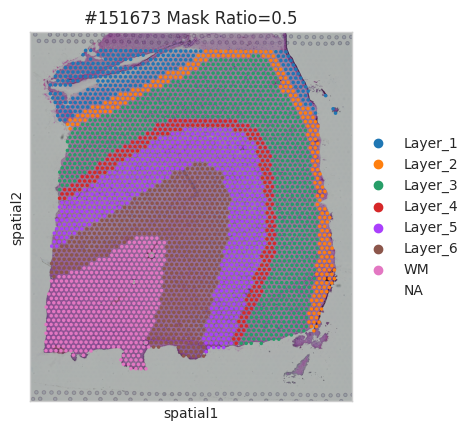

In [7]:
sc.pl.spatial(adata_hvg, img_key="hires", 
              color=["Ground Truth"], 
              title=[f'#{section} Mask Ratio={mask_ratio}'])

In [8]:
cps_model = CPS.CPSTrainer(args)
cps_model.fit(train_data, print_every=100)

  0%|          | 0/1000 [00:00<?, ?it/s]


Epoch   0: Train[Total:2.0054, T:0.6552, S:0.5800, D:0.7701]

Epoch 100: Train[Total:0.9815, T:0.3975, S:0.3489, D:0.2350]

Epoch 200: Train[Total:0.9529, T:0.3856, S:0.3503, D:0.2169]

Epoch 300: Train[Total:0.8716, T:0.3800, S:0.3497, D:0.1418]

Epoch 400: Train[Total:0.8154, T:0.3768, S:0.3494, D:0.0892]

Epoch 500: Train[Total:0.7827, T:0.3753, S:0.3519, D:0.0554]

Epoch 600: Train[Total:0.7599, T:0.3745, S:0.3503, D:0.0350]

Epoch 700: Train[Total:0.7466, T:0.3746, S:0.3489, D:0.0230]

Epoch 800: Train[Total:0.7380, T:0.3750, S:0.3476, D:0.0154]

Epoch 900: Train[Total:0.7332, T:0.3748, S:0.3473, D:0.0111]

Epoch 999: Train[Total:0.7310, T:0.3754, S:0.3475, D:0.0080]


Compute the metrics on test dataset

In [9]:
metrics = cps_model.evaluate_genes_imputation(test_data, mask_pattern=mask_pattern,
                                              use_log1p=True, experiment_name='DLPFC_GI')

Performing genes imputation evaluation...
Total entries: 10917000, Masked entries: 5458500 (50.0%)

Computing GENE metrics on **Log1p Transformed** data (Masked only)...

Spatial imputation metrics [Log1p Transformed]

[global flatten metrics]
MSE:           0.064106
RMSE:          0.253192
MAE:           0.138576
R²:            0.622394
Pearson:       0.791710
Spearman:      0.498591

[sample mean metrics]
CS:               0.784394
CS nonzero:       0.873599
Pearson:          0.754851
Pearson nonzero:  0.740123
Spearman:         0.483365
Spearman nonzero: 0.629599
SAM:              37.883558°
SAM nonzero:      28.740485°
MSE:              0.064106
MSE nonzero:      0.287944
MAE:              0.138576
MAE nonzero:      0.464462

 num of sample: 3639.0
Metrics saved to: ./results/DLPFC_GI_metrics.json


### Analysis of the imputed gene expression

In [10]:
# mask_ratio=0 to get all the inference data
imputed_expr, z_s = cps_model.infer_postion(test_data)
imputed_expr.shape

torch.Size([3639, 3000])

In [11]:
adata_hvg.layers['imputed'] = imputed_expr.detach().cpu().numpy()
adata_hvg.obsm['z_s'] = z_s.detach().cpu().numpy()
adata_hvg

AnnData object with n_obs × n_vars = 3639 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p', 'Ground Truth_colors'
    obsm: 'spatial', 'hvg_features', 'hvg_counts', 'z_s'
    layers: 'counts', 'imputed'

In [12]:
adata_hvg.layers['log1p_raw'] = np.log1p(adata_hvg.layers['counts']) 
adata_hvg.layers['log1p_imputed'] = np.log1p(adata_hvg.layers['imputed'])

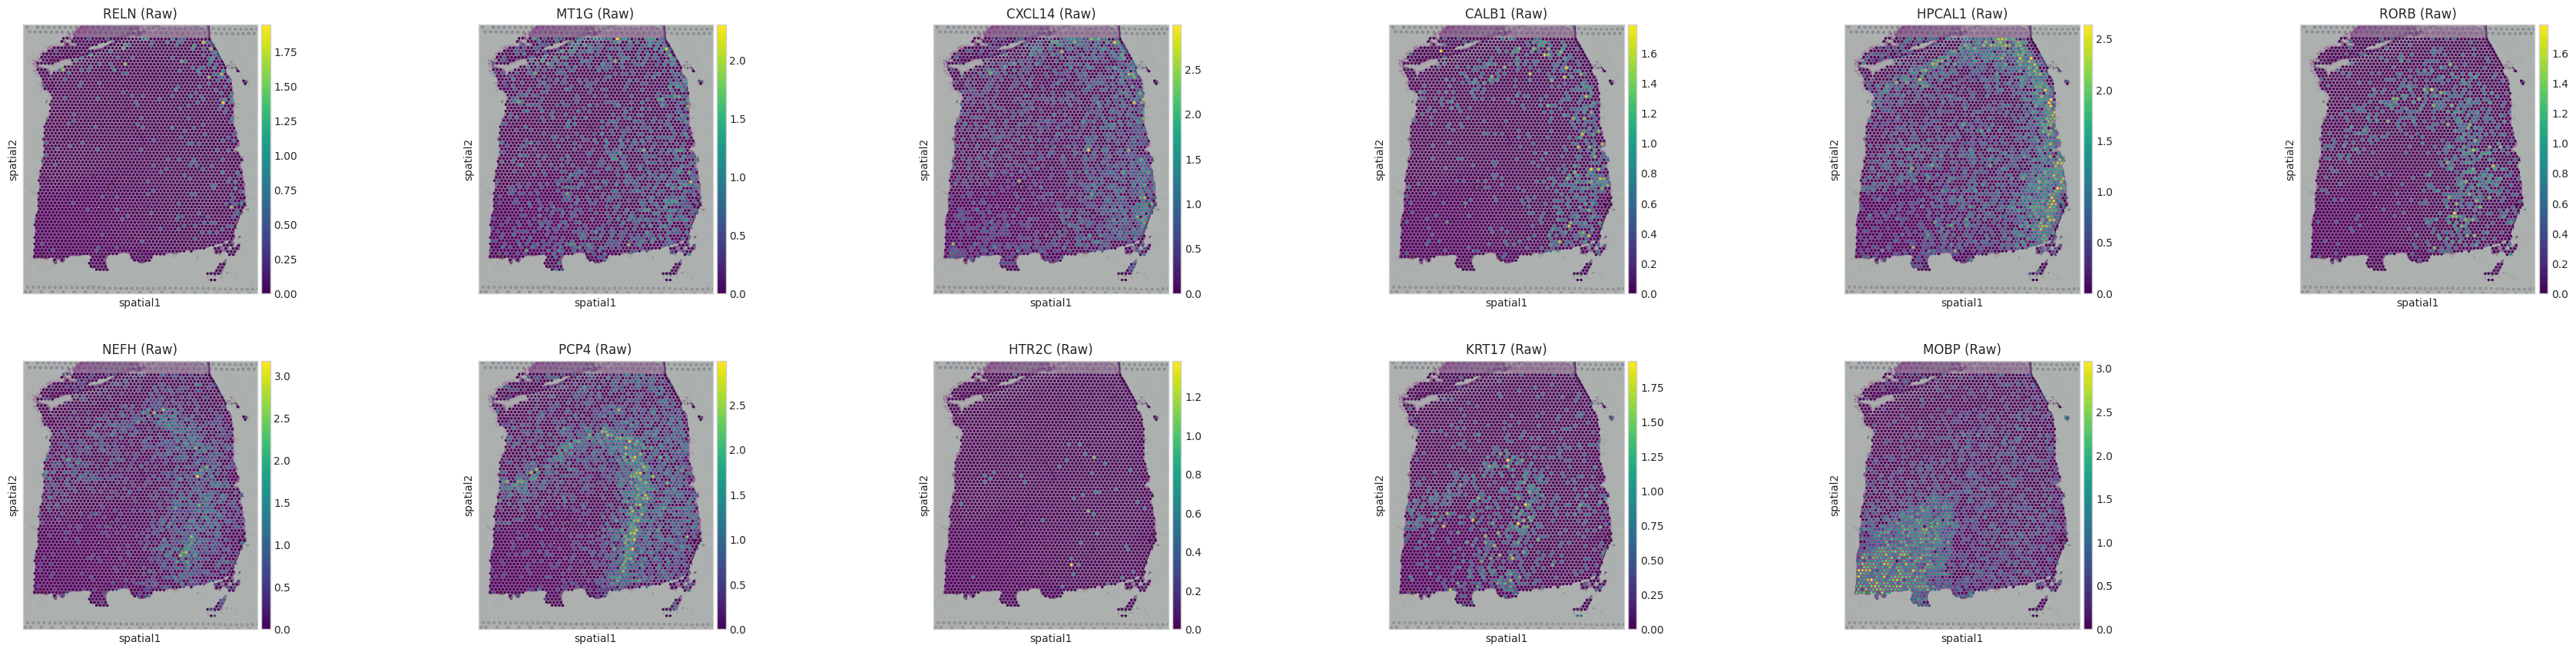

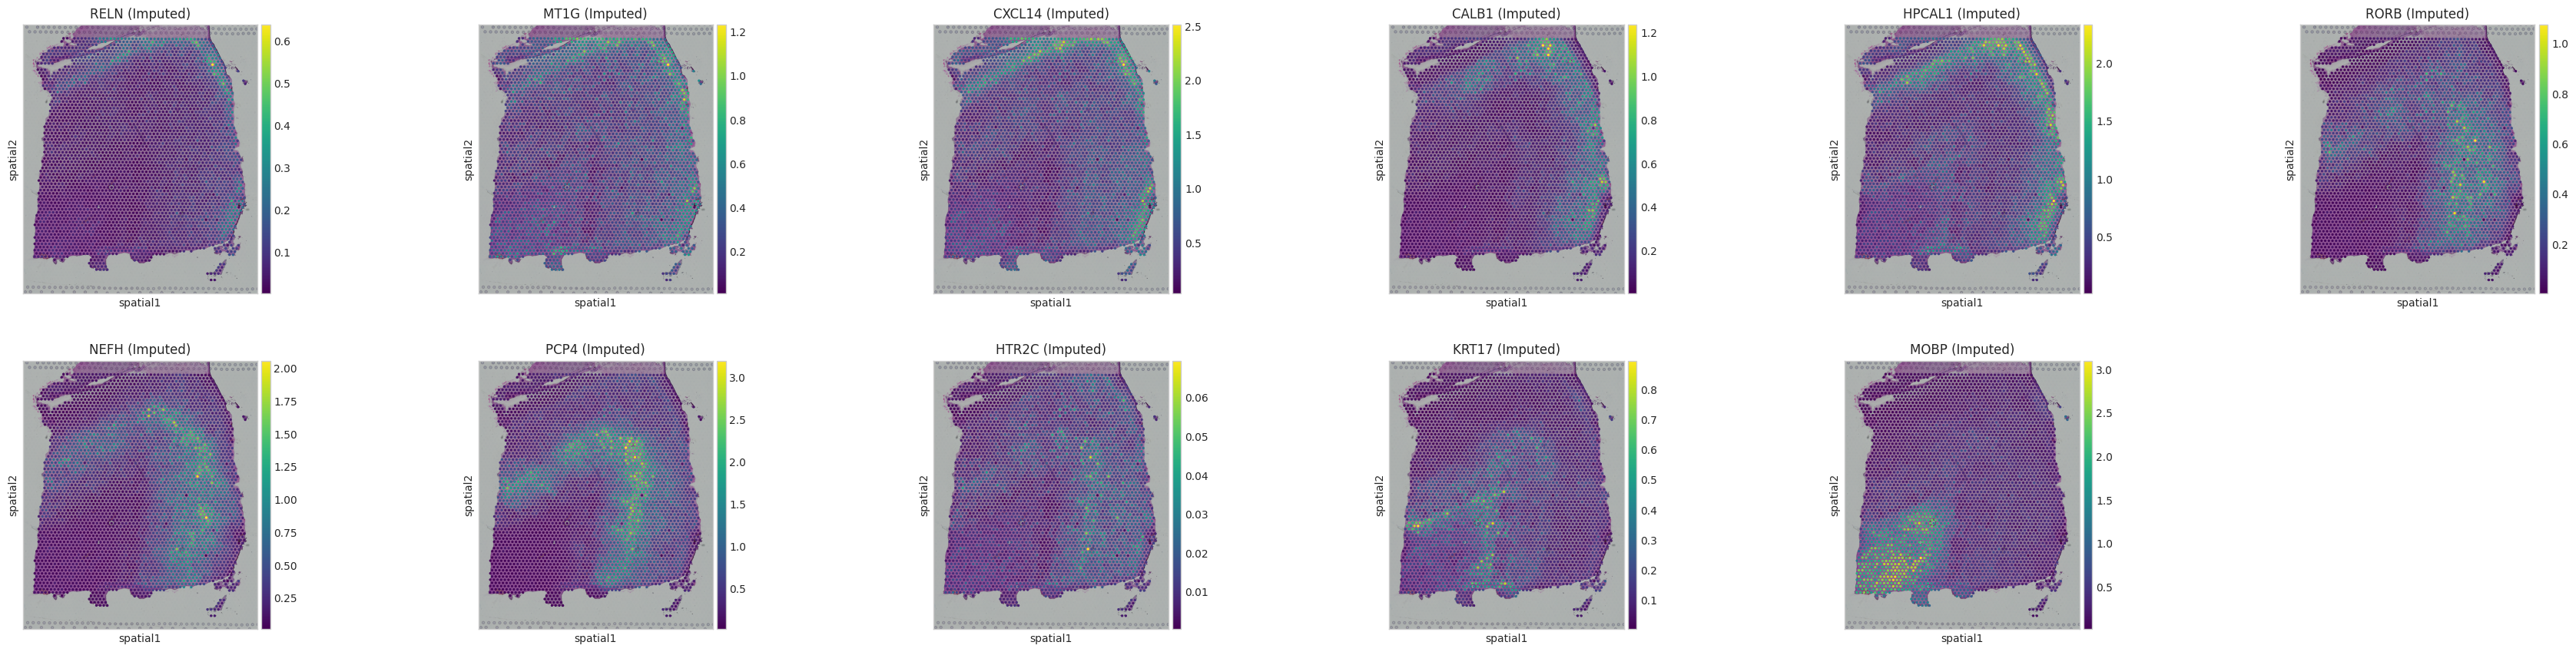

In [13]:
genes_to_plot = [
    'RELN',    # Layer 1
    'MT1G',    # Layer 1
    'CXCL14',  # Layer 2
    'CALB1',   # Layer 2
    'HPCAL1',  # Layer 2/3
    'RORB',    # Layer 4 
    'NEFH',    # Layer 4
    'PCP4',    # Layer 5 
    'HTR2C',   # Layer 5
    'KRT17',   # Layer 6
    'MOBP'     # White Matter
]

sc.pl.spatial(adata_hvg, cmap='viridis',
              color=genes_to_plot, layer='log1p_raw', 
              title=[f"{g} (Raw)" for g in genes_to_plot], ncols=6)
sc.pl.spatial(adata_hvg, cmap='viridis',
              color=genes_to_plot, layer='log1p_imputed',
              title=[f"{g} (Imputed)" for g in genes_to_plot], ncols=6)

In [ ]:
genes_to_plot = [
    'RELN',    # Layer 1
    'MT1G',    # Layer 1
    'CXCL14',  # Layer 2
    'CALB1',   # Layer 2
    'HPCAL1',  # Layer 2/3
    'RORB',    # Layer 4 
    'NEFH',    # Layer 4
    'PCP4',    # Layer 5 
    'HTR2C',   # Layer 5
    'KRT17',   # Layer 6
    'MOBP'     # White Matter
]

sc.pl.spatial(adata_hvg, cmap='viridis',
              color=genes_to_plot, layer='log1p_raw', 
              title=[f"{g} (Raw)" for g in genes_to_plot], ncols=6)
sc.pl.spatial(adata_hvg, cmap='viridis',
              color=genes_to_plot, layer='log1p_imputed',
              title=[f"{g} (Imputed)" for g in genes_to_plot], ncols=6)

[<Axes: xlabel='UMAP1', ylabel='UMAP2'>, <Axes: >]

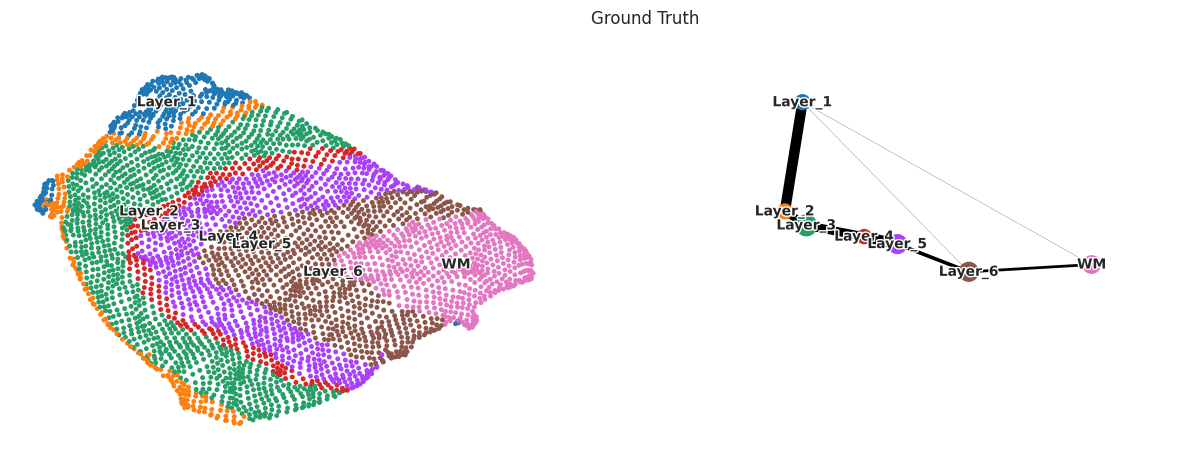

In [14]:
sc.pp.neighbors(adata_hvg, use_rep='z_s')
sc.tl.umap(adata_hvg)
adata_hvg = adata_hvg[adata_hvg.obs['Ground Truth'].notna(),:]
sc.tl.paga(adata_hvg, groups='Ground Truth')
sc.pl.paga_compare(adata_hvg, frameon=False, size=50, 
                   legend_fontoutline=2, show=False)